In [6]:
import time
import os
import numpy as np
#import easygui
import PySimpleGUI as sg
import pandas as pd
import matplotlib.pyplot as plt
import functions as f
#import easygui as gui
from multiprocessing import Pool, Process, freeze_support, set_start_method
from multiprocessing import cpu_count
from tqdm import tqdm


if __name__ == '__main__':
    
    layout = [
        [sg.Text('Select AVi File recording', 
                 size=(35, 1)), 
                 # sg.In(default_text='Select a video'), 
                 sg.FileBrowse(initial_folder='/media/erick/NuevoVol/LINUX_LAP/PhD/')],
        [sg.Text('Refraction index of media (water = 1.3226)', size=(35, 1)), sg.InputText(default_text=1.3226)],
        [sg.Text('Wavelength in um (~0.642)', size=(35, 1)), sg.InputText(default_text=0.642)],
        [sg.Text('Magnification (10, 20, etc)', size=(35, 1)), sg.InputText(default_text=10)],
        [sg.Text('Step size (10)', size=(35, 1)), sg.InputText(default_text=10)],
        [sg.Text('Number os steps (150)', size=(35, 1)), sg.InputText(default_text=150)],
        [sg.Text('Gradient Stack Threshold (~0.1)', size=(35, 1)), sg.InputText(default_text=0.1)],
        [sg.Text('Peak Min Distance (20, 40, 60)', size=(35, 1)), sg.InputText(default_text=20)],
        [sg.Text('Frame Rate', size=(35, 1)), sg.InputText(default_text=50)],
        [sg.Checkbox('Invert Video', default=False)],
        [sg.Checkbox('Export as CSV', default=False)],
        [sg.Text('Number of frames for calculations', size=(35, 1)), sg.InputText(default_text='')],
        [sg.Button('Add File'), sg.Button('Done'), sg.Cancel()]
        
    ]
    
    window = sg.Window('Holography video inputs', layout)
    
    PATH = []
    N = []
    LAMBDA = []
    MPP = []
    SZ = []
    NUMSTEPS = []
    THRESHOLD = []
    PMD = []
    FRAME_RATE = []
    INVERT_VIDEO = []
    export = []
    num_frames = []

    while True:
        event, values = window.Read()
        values = list(values.values())
        if event == 'Cancel': # or event == sg.WIN_CLOSED
            break
        elif event == 'Done':
            break
        elif event == 'Add File':   
            print('File '+os.path.split(values[0])[-1]+' added to queue')
            PATH.append(values[0])
            N.append(float(values[1]))
            LAMBDA.append(float(values[2]))
            MPP.append(int(values[3]))
            SZ.append(float(values[4]))
            NUMSTEPS.append(int(values[5]))
            THRESHOLD.append(float(values[6]))
            PMD.append(int(values[7]))
            FRAME_RATE.append(int(values[8]))
            INVERT_VIDEO.append(values[9])          
            export.append(values[10])
            if values[11] == '':
                num_frames.append([])
            else:
                num_frames.append(int(values[11]))
            
    window.Close()
    print('-------------------------------------------------')
    
 #%%
    
    # ### Coordinate detection
    data = []
    # times = []
    for k in range(len(PATH)): 
        VID = f.videoImport(PATH[k], 0)
        ni, nj, nk = np.shape(VID)
        
        
        if INVERT_VIDEO[k]:
            for i in range(nk):
                VID[:, :, i] = VID[:, :, i].max() - VID[:, :, i]
    
        FRAMES_MEDIAN = 20
        I_MEDIAN = f.medianImage(VID, FRAMES_MEDIAN)
        # I_MEDIAN = np.ones((VID.shape[0], VID.shape[1]))
        
        if num_frames[k] == []:
            NUM_FRAMES = nk
        else:
            NUM_FRAMES = num_frames[k]
            
        IT = np.empty((NUM_FRAMES), dtype=object)
        MED = np.empty((NUM_FRAMES), dtype=object)
        n = np.empty((NUM_FRAMES), dtype=object)
        lam = np.empty((NUM_FRAMES), dtype=object)
        mpp = np.empty((NUM_FRAMES), dtype=object)
        sz = np.empty((NUM_FRAMES), dtype=object)
        numsteps = np.empty((NUM_FRAMES), dtype=object)
        threshold = np.empty((NUM_FRAMES), dtype=object)
        pmd = np.empty((NUM_FRAMES), dtype=object)
        
        for i in range(NUM_FRAMES):
            IT[i] = VID[:, :, i]
            MED[i] = I_MEDIAN
            n[i] = N[k]
            lam[i] = LAMBDA[k]
            mpp[i] = MPP[k]
            sz[i] = SZ[k]
            numsteps[i] = NUMSTEPS[k]
            threshold[i] = THRESHOLD[k]
            pmd[i] = PMD[k]
        
        pool = Pool(cpu_count())
        results = []
    #     T0 = time.time()
    
        print('Processing File: '+ os.path.split(PATH[k])[-1])
        for _ in tqdm(pool.imap_unordered(f.positions_batch, zip(IT, MED, n, lam, mpp, sz, numsteps, threshold, pmd)), 
                      total=NUM_FRAMES):
            results.append(_)
        pool.close()
        pool.join()
        
        POSITIONS = pd.DataFrame(columns=['X', 'Y', 'Z', 'I_FS', 'I_GS', 'FRAME', 'TIME'])
        for i in range(NUM_FRAMES):
    
            X = results[i][0][0]
            Y = results[i][1][0]
            Z = results[i][2][0]
            I_FS = results[i][3][0]
            I_GS = results[i][4][0]
            FRAME = i*np.ones_like(results[i][0][0])
            TIME = i*np.ones_like(results[i][0][0])
            
            DATA = np.concatenate((np.expand_dims(X, axis=1), 
                                   np.expand_dims(Y, axis=1), 
                                   np.expand_dims(Z, axis=1), 
                                   np.expand_dims(I_FS, axis=1), 
                                   np.expand_dims(I_GS, axis=1), 
                                   np.expand_dims(FRAME, axis=1), 
                                   np.expand_dims(FRAME*(1/FRAME_RATE[k]), axis=1)), 
                                  axis=1)
            POSITIONS = POSITIONS.append(pd.DataFrame(DATA, 
                                                      columns=['X', 'Y', 'Z', 'I_FS', 'I_GS', 'FRAME', 'TIME']))
            
        if export[k]:
            path = os.path.split(PATH[k])[:-1][0]
            pp = os.path.split(PATH[k])[-1][:-4]
            expath = path+'/'+pp+'_TH'+str(THRESHOLD[k])+'_PMD'+str(PMD[k])+'_SZ'+str(SZ[k])+'_NUMSTEPS'+str(NUMSTEPS[k])+'.csv'
            POSITIONS.to_csv(expath)
            print('Exported to: \n', expath)
            print('-------------------------------------------------')
               
        
    #     T = time.time - T0
    #     times.append(T)
        data.append(POSITIONS)
        
    print('Done!')

-------------------------------------------------
Done!


In [3]:
#%% Plot with plotly.graph_objects
import easygui as gui
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode

init_notebook_mode(connected=True) 

# # To plot csv files
PATH = gui.fileopenbox(default='/media/erick/NuevoVol/LINUX_LAP/PhD/', filetypes='.csv')
# POSITIONS = pd.read_csv(PATH, index_col=0)
POSITIONS = pd.read_csv(PATH)
# POSITIONS = data[0]

fig = go.Figure(data=[go.Scatter3d(
    x=POSITIONS['X'], 
    y=POSITIONS['Y'], 
    z=POSITIONS['Z'],
    mode='markers', 
    marker=dict(
        size=1,
        color=POSITIONS['FRAME'].values,
        colorscale='Viridis'
        ),
    hovertext=['X+Y+Z+FRAME'],
    hoverinfo='all'
    
)])

fig['layout']['scene']['aspectmode'] =  'cube'
fig.show()
# iplot(fig)     # To show externatlly

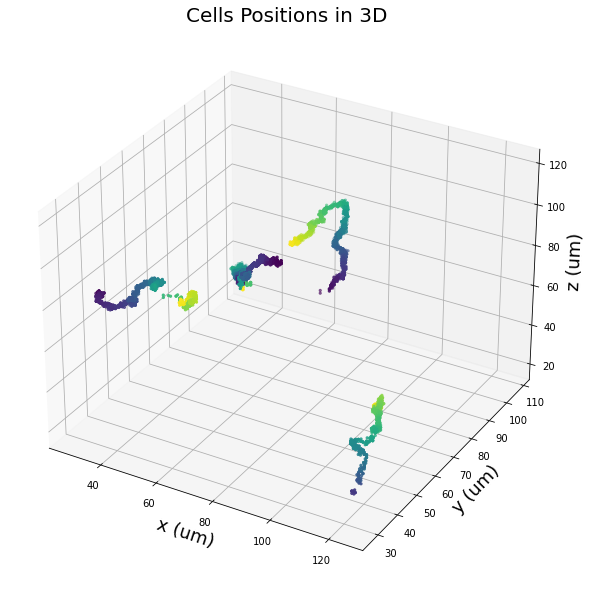

In [5]:
import easygui as gui
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
# %matplotlib qt
%matplotlib inline


# path = gui.fileopenbox(default='/media/erick/NuevoVol/LINUX_LAP/', multiple=False)
# path = gui.fileopenbox()
# POSITIONS = pd.read_csv(path)
#     POSITIONS = data[0]

#POSITIONS = POSITIONS[POSITIONS['X'] > 10]
X = POSITIONS.X
Y = POSITIONS.Y
Z = POSITIONS.Z
T = POSITIONS.TIME

fig = pyplot.figure(figsize=(10, 15))
ax = pyplot.axes(projection='3d')

ax.scatter(X, Y, Z, s=5, marker='o', c=T)
#ax.plot(Y, X, Z)
ax.tick_params(axis='both', labelsize=10)
ax.set_title('Cells Positions in 3D', fontsize='20')
ax.set_xlabel('x (um)', fontsize='18')
ax.set_ylabel('y (um)', fontsize='18')
ax.set_zlabel('z (um)', fontsize='18')

pyplot.show()

In [4]:
x = X.values
y = Y.values
z = Z.values
t = T.values

b =[]
for k in range(len(x)):
    if x[k] < 100 and y[k] < 100:
        b.append(True)
    else:
        b.append(False)
# plt.scatter(X[b], Y[b])
plt.plot(X[b], Y[b])

In [6]:
fig = pyplot.figure(figsize=(10, 15))
ax = pyplot.axes(projection='3d')

ax.scatter(x[b], y[b], z[b], s=5, marker='o', c=t[b])
# ax.plot(x[b], y[b], z[b])
ax.tick_params(axis='both', labelsize=10)
ax.set_title('Cells Positions in 3D', fontsize='20')
ax.set_xlabel('x (um)', fontsize='18')
ax.set_ylabel('y (um)', fontsize='18')
ax.set_zlabel('z (um)', fontsize='18')

pyplot.show()
    